

> Saif Ur Rahman, 22100001




### Task 2

In this task you will work with time series data to create a forecasting model. You will 
- Preprocess the data and create slices
- Build the model and train it on your data
- Repeat the above for these values of sequence length `(5, 10, 15)`
- Think of some quantitative or qualitative way to compare the **fit** (prediction on train set) along with the **forecasting** capability (prediction on test set) and provide your conclusions at the end.



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from tqdm import tqdm_notebook as tqdm
import os
from datetime import datetime
from sklearn.metrics import mean_absolute_error


#add other libarry which you need
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### The Data

We will be generating synthetic time-series data since real data of this kind has a lot of noise and would require considerable management and training to achieve decent predictions.

You can imagine this data is about the sales of a product or global average temperatures over time. 

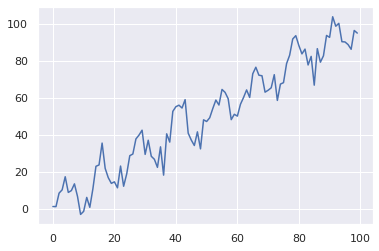

In [ ]:
def dither(v):
    return np.random.normal(loc=v, scale=5)

np.random.seed(43)
x = np.arange(100)
y = x + 10*np.sin(0.5*x)
data = np.array([dither(v) for v in y])
plt.plot(data);

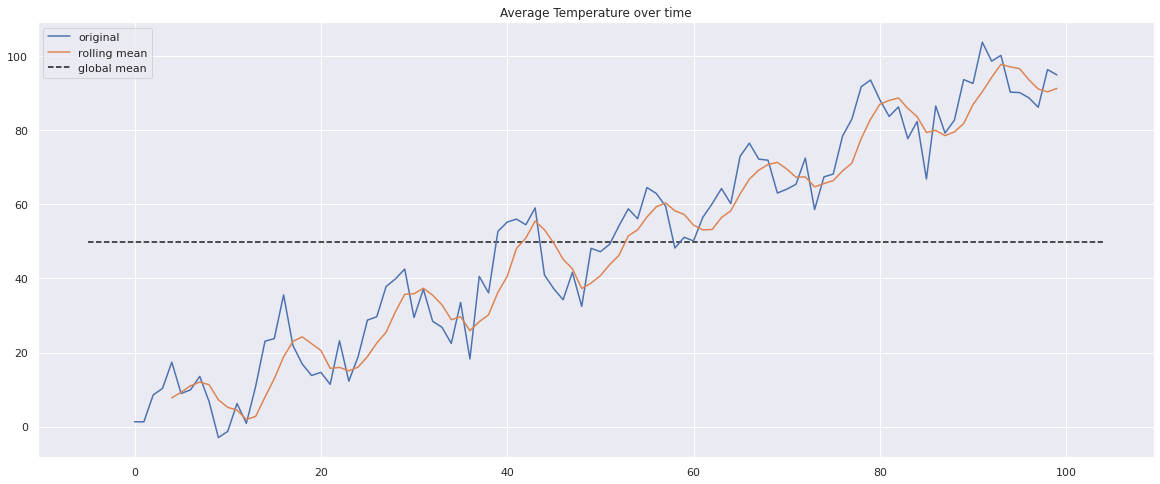

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(data, label='original');
ax.plot(pd.Series(data).rolling(5).mean(), label='rolling mean');
ax.hlines([data.mean()], ax.get_xlim()[0], ax.get_xlim()[1], 
          color='k', linestyle='dashed', label='global mean');
ax.legend();
ax.set_title('Average Temperature over time');

The data has both short-term (seasonality) and long-term (trend) patterns but there is also a lot of noise. This is why you will often see time series handled as a **stochastic process** (one involving random variables). The dashed black line is the global mean shown as a reference value to judge peaks and dips against. 

The orange line is a smoothed curve which follows the same trends as the blue curve. This is called the **rolling mean**. This is the result of convolving the signal (blue curve) with a 1D mean blur kernel.  

This is not a **stationary** time-series and we will not be concerned with this issue during this assignment. 

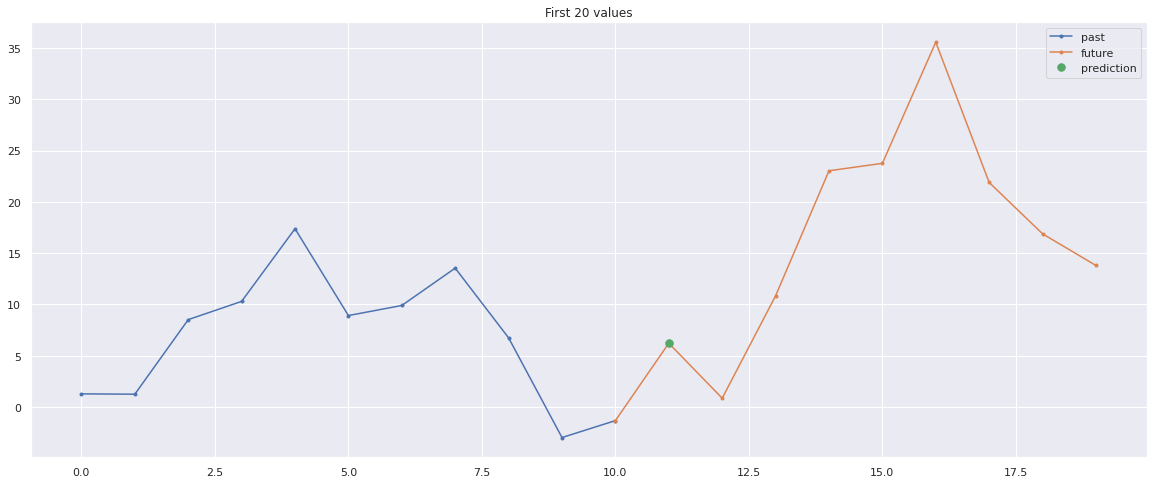

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
chunk = data[:20]
ax.plot(np.arange(0,11), chunk[:11], '.-', label='past');
ax.plot(np.arange(10,20), chunk[10:], '.-', label='future');
ax.plot([11], chunk[11], '.', markersize=15, label='prediction');
ax.legend();
ax.set_title('First 20 values');

Zooming into the first 20 values we can much more easily see the individual data points. The blue line is considered the past and the green line is the future. In this setup we have to make predictions in the future based on patterns we have learned from the past. We accomplish this by using a **slice** of data as input to our model and predict the very next value (green dot). We keep doing this until we have all the predictions. 

In [ ]:
data.shape

(100,)

We can't randomly split the data into training and testing sets. Both sets have to be contiguous in time otherwise we are basically destroying the data. 

Let's split the data so that about half the series is in the past and half is in the future where we will make predictions. I this framework the past is our training set and the future is our test set.

In [ ]:
train = data[:50]
test  = data[50:]

In [ ]:
data.min(), data.mean(), data.max()

(-2.9713754609891403, 49.84289209763272, 103.8306061991388)

### Processing

In [ ]:
def make_slices(series, window):
    num_rows = len(series)
    # print(num_rows)
    num_slices = num_rows - window + 1
    # print("Num slices:", num_slices)
    slices = np.zeros((num_slices, window))
    
    # fill your code
    for i in range((num_slices)):
      slices[i] = series[i:i+window]
      # print(slices[i])
      # print(i)
    
    return slices

The `sequence_len` hyperparameter controls how far in the past the model can see in order to predict the future. The `num_feats` parameter is the number of distinct features we are inputting into the model. For now we just have one variable which we are learning from so it is set equal to 1. 

We can have multiple input and output features from a recurrent model.

In [ ]:
sequence_len = 10
num_feats = 1

In [ ]:
train_slices = make_slices(train, sequence_len+1)

In [ ]:
train_slices.shape

(40, 11)

In [ ]:
train_x = train_slices[:, 0:-1]
train_y = train_slices[:,-1]

train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], num_feats))

train_x.shape, train_y.shape

((40, 10, 1), (40,))

Let's make sure the `make_slices` function works correctly.

In [ ]:
(train_x[1:,-1,0] == train_y[:-1]).all()

True

### The Model

In [ ]:
model_name = f"lstm_{sequence_len}"
if not os.path.exists(model_name):
    os.mkdir(model_name)

In [ ]:
## Add your code for you model here

In [ ]:
# define model
from keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(sequence_len, num_feats)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
#train your model 
# fit model
model.fit(train_x, train_y, epochs=200, verbose=0)

In [ ]:
#save weight 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# save entire model
model.save('/content/drive/MyDrive/Deep Learning/A6/saved_model/my_model') 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Deep Learning/A6/saved_model/my_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Deep Learning/A6/saved_model/my_model/assets


### Making Predictions

Let's check how the model does with the training data.

In [ ]:
test_input = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
test_input = test_input.reshape((1, sequence_len, num_feats))
yhat = model.predict(test_input, verbose=0)
print(yhat)

[[39.281525]]


Now let's make proper predictions using slices of training data.

In [ ]:
#write your code here
train_compare = []
for i in range(len(train_x)):
  prediction = model.predict(train_x[i].reshape((1, sequence_len, num_feats)), verbose=0)
  train_compare.append(prediction[0][0])

In [ ]:
print(train_compare)

[-0.80828327, 6.013978, 1.1798918, 10.232037, 22.921183, 24.021992, 34.863262, 20.943424, 16.392117, 13.649707, 14.093424, 11.946585, 20.635649, 12.605618, 19.130556, 28.00054, 29.202824, 38.257492, 38.420307, 39.436954, 27.850122, 33.735752, 26.396471, 25.864075, 21.878603, 32.414654, 19.176716, 42.442127, 34.454082, 53.161522, 53.476524, 54.688187, 53.300503, 54.50718, 38.031002, 34.95512, 32.516197, 39.54169, 31.129944, 46.562553]


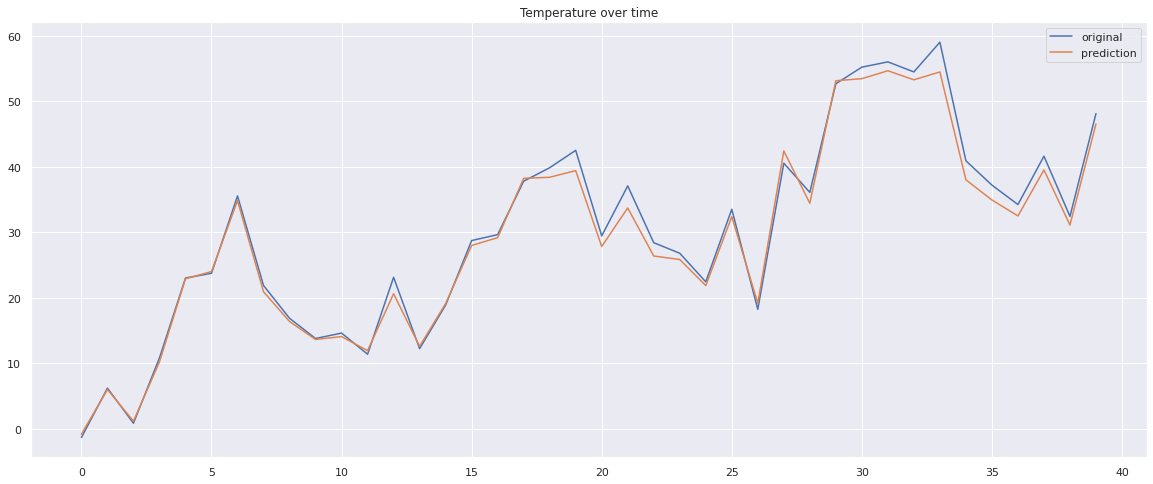

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(train_y, label='original');
ax.plot(train_compare, label='prediction');
ax.legend();
ax.set_title('Temperature over time');

We can see the model has picked up on both the seasonality as well as the trend. 

Now let's do the same thing for test data. This is the **forecasting** stage. 

In [ ]:
test_slices = make_slices(test, sequence_len+1)
test_x = test_slices[:, 0:-1]
test_y = test_slices[:,-1]
test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], num_feats))

d0 = np.append(test_x[-1,1:,:], test_y[-1])
test_compare = []
for i in tqdm(range(len(test_x))):
    d0 = d0.reshape(1,sequence_len,num_feats)
    pred = model.predict(d0)[0][0]
    test_compare.append(pred)
    d0 = np.append(d0[-1,1:,:], pred)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
test_compare

[59.76598,
 71.22084,
 59.831352,
 57.5538,
 50.983017,
 68.92645,
 55.673733,
 69.72574,
 61.997406,
 86.246765,
 80.46761,
 88.97526,
 57.970905,
 61.824165,
 48.809494,
 46.276848,
 42.61576,
 56.589634,
 46.691742,
 62.500225,
 59.97379,
 84.57347,
 65.86498,
 82.09582,
 62.12245,
 53.616005,
 43.941765,
 47.685905,
 38.310844,
 53.492615,
 40.69518,
 61.057533,
 59.486637,
 93.699135,
 64.40082,
 81.94569,
 68.96252,
 46.2238,
 44.837498,
 43.050568]

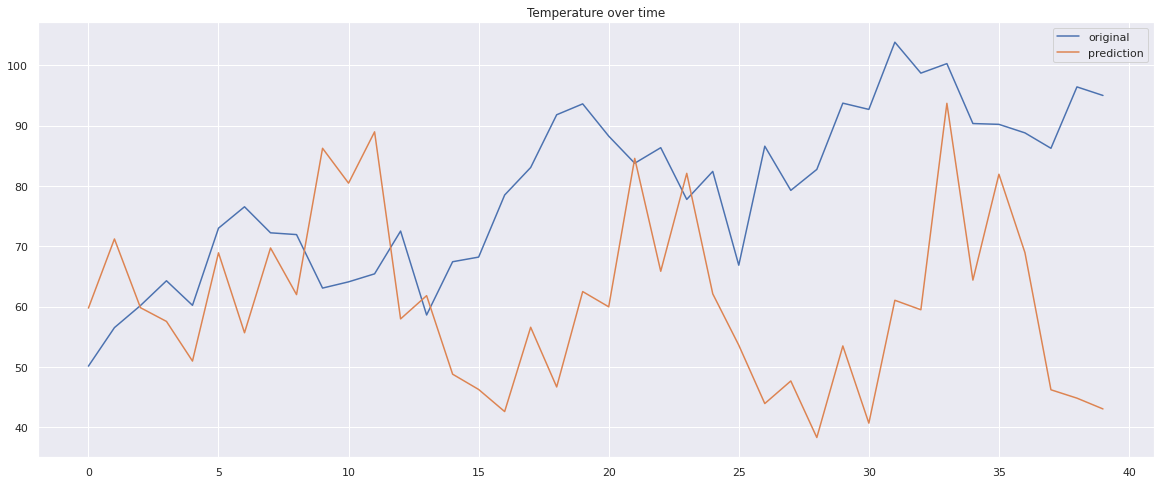

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(test_y, label='original');
ax.plot(test_compare, label='prediction');
ax.legend();
ax.set_title('Temperature over time');

Again, the model is working very decently.  

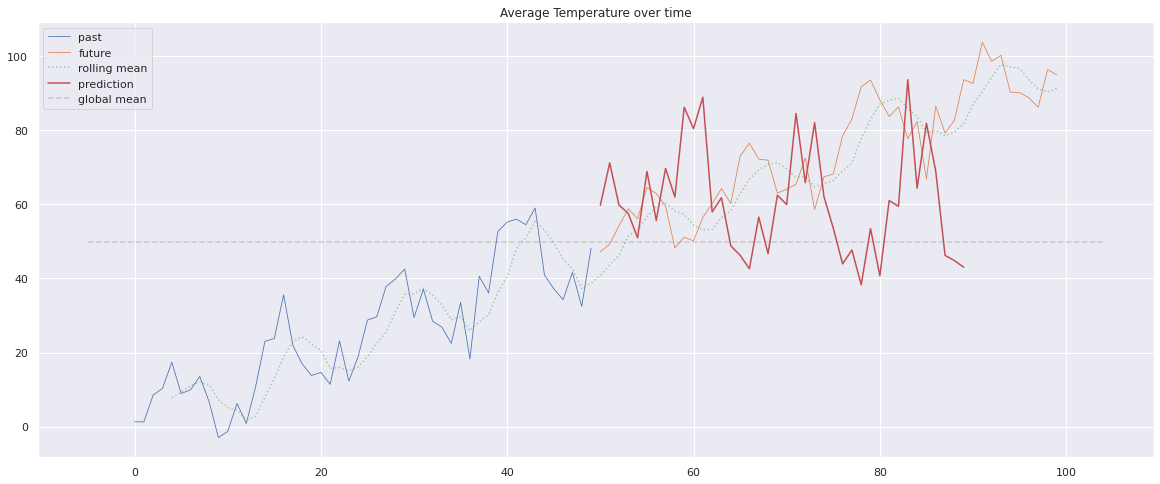

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(np.arange(0,50), train, linewidth=0.8, label='past');
ax.plot(np.arange(50,100), test, linewidth=0.8, label='future');
ax.plot(pd.Series(data).rolling(5).mean(), 
        alpha=0.5, linestyle='dotted', label='rolling mean');
ax.plot(np.arange(50,90), test_compare, label='prediction');
ax.hlines([data.mean()], ax.get_xlim()[0], ax.get_xlim()[1], 
          color='grey', alpha=0.3, linestyle='dashed', label='global mean');
ax.legend();
ax.set_title('Average Temperature over time');